In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

height_lr = 136
width_lr = 180
channels = 3
shape_lr = (height_lr, width_lr, channels)
shape_hr = (4*height_lr, 4*width_lr, channels)
data_num = 7
data_dir = f"../../datasets/dataset_0{data_num}/"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25
learning_rate = 0.0002
batch_size = 1

## Encoder: Conv2D, BatchNormalize, MaxPooling
## Decoder: UpSampling, Conv2D, BatchNormalize, Add

In [2]:
input_img = Input(shape=(136, 180, 3))

l1_1 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l1_2 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_1)
l1_3 = BatchNormalization()(l1_2)
l1_4 = MaxPooling2D(padding='same')(l1_2)
l1_5 = Dropout(0.25)(l1_4)
l2_1 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_5)
l2_2 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_1)
l2_3 = BatchNormalization()(l2_2)          
l2_4 = MaxPooling2D(padding='same')(l2_3)
l3_1 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_4)
l3_2 = BatchNormalization()(l3_1)
encoder = Model(input_img, l3_2)
encoder.summary()

l4_1 = UpSampling2D()(l3_1)
l4_2 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_1)
l4_3 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_2)
l4_4 = BatchNormalization()(l4_3)
l5_1 = add([l2_2, l4_4])
l5_2 = UpSampling2D()(l5_1)
l5_3 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_2)
l5_4 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_3)
l5_5 = BatchNormalization()(l5_4)
l6_1 = add([l5_5, l1_2])
l6_2 = UpSampling2D()(l6_1)
l6_3 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6_2)
l6_4 = Conv2D(3, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6_3)
autoencoder = Model(input_img, l6_4)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 136, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 136, 180, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 136, 180, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 90, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 68, 90, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 90, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 90, 128)       147584

## Encoder: Conv2D, MaxPooling
## Decoder: UpSampling, Conv2D, Add

In [2]:
#Upsampling
input_img = Input(shape=(136, 180, 3))

l1_1 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l1_2 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_1)
l1_3 = MaxPooling2D(padding='same')(l1_2)
l1_4 = Dropout(0.25)(l1_3)
l2_1 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1_4)
l2_2 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_1)    
l2_3 = MaxPooling2D(padding='same')(l2_2)
l3_1 = Conv2D(256, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2_3)

l4_1 = UpSampling2D()(l3_1)
l4_2 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_1)
l4_3 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4_2)
l5_1 = add([l2_2, l4_3])
l5_2 = UpSampling2D()(l5_1)
l5_3 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_2)
l5_4 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l5_3)
l6_1 = add([l5_4, l1_2])
l6_2 = UpSampling2D()(l6_1)
l6_3 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6_2)
l6_4 = Conv2D(3, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6_3)
autoencoder = Model(input_img, l6_4)
autoencoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 136, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 136, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 136, 180, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 68, 90, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Encoder: Conv2D, MaxPooling
## Decoder: Conv2DTranspose, Conv2D, Add

In [2]:
#Input
input_img = Input(shape=(136, 180, 3))

#Encoder
l1_1 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(input_img)
l1_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = MaxPooling2D(padding='same')(l1_2)
#l1_4 = Dropout(0.25)(l1_3)
l2_1 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_1)    
l2_3 = MaxPooling2D(padding='same')(l2_2)
l3_1 = Conv2D(256, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_3)

#Decoder
l4_1 = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l3_1)
l4_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l4_1)
l4_3 = add([l4_2, l2_2])
l5_1 = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l4_3)
l5_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l5_1)
l5_3 = add([l5_2, l1_2])
l6_1 = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l5_3)
l6_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l6_1)

#Output
l6_3 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizers.l1(10e-10))(l6_2)
autoencoder = Model(input_img, l6_3)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 136, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 136, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 136, 180, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 68, 90, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Encoder: Conv2D(Stride=(1,1)), Conv2D(Stride=(2,2))
## Decoder: Conv2DTranspose, Conv2D(Stride=(1,1)), add

In [2]:
input_img = Input(shape_lr)

#Encoder
l1_1 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(input_img)
l1_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = Dropout(dropout_ratio)(l1_2)
l2_1 = Conv2D(128, (3,3), strides=(2,2), padding='same', activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = Dropout(dropout_ratio)(l2_2)
l3_1 = Conv2D(256, (3,3), strides=(2,2), padding='same', activation=activation,
            activity_regularizer=regularizer)(l2_3)

#Decoder
l4_1 = Conv2DTranspose(128, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l3_1)
l4_2 = Conv2D(128, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l4_1)
l4_3 = add([l4_2, l2_2])
l5_1 = Conv2DTranspose(64, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l4_3)
l5_2 = Conv2D(64, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l5_1)
l5_3 = add([l5_2, l1_2])
l6_1 = Conv2DTranspose(32, (3,3), padding='same', strides=(2,2),
            activation=activation, activity_regularizer=regularizer)(l5_3)
l6_2 = Conv2D(32, (3,3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l6_1)

#Output
l7_1 = Conv2D(3, (3, 3), padding='same', activation=activation,
            activity_regularizer=regularizer)(l6_2)

autoencoder = Model(input_img, l7_1)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 136, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 136, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 136, 180, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 136, 180, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Encoder: Conv2D(stride=(2,2), activation=None), BatchNormization, Activation
## Decoder: Conv2DTranspose(stride=(2,2), activation=None), Conv2D(activation=None), Activation, Add

In [31]:
img_input = Input(shape_lr)

l1_1 = Conv2D(64, (7,7), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(img_input)
l1_2 = BatchNormalization()(l1_1)
l1_3 = Activation(activation=activation, activity_regularizer=regularizer)(l1_2)

l2_1 = Conv2D(128, (3,3), padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l2_1)
l2_3 = BatchNormalization()(l2_2)
l2_4 = Activation(activation=activation, activity_regularizer=regularizer)(l2_3)

l3_1 = Conv2D(256, (3,3), padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l2_4)
l3_2 = Conv2D(256, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l3_1)
l3_3 = BatchNormalization()(l3_2)
l3_4 = Activation(activation=activation, activity_regularizer=regularizer)(l3_3)

l4_1 = Conv2DTranspose(128, (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l3_4)
l4_2 = Conv2D(128, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l4_1)
l4_3 = BatchNormalization()(l4_2)
l4_4 = Activation(activation=activation, activity_regularizer=regularizer)(l4_3)

l5 = add([l4_4, l2_4])

l6_1 = Conv2DTranspose(64, (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l5)
l6_2 = Conv2D(64, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l6_1)
l6_3 = BatchNormalization()(l6_2)
l6_4 = Activation(activation=activation, activity_regularizer=regularizer)(l6_3)

l7 = add([l6_4, l1_3])

l8_1 = Conv2DTranspose(32, (3,3),padding='same', strides=(2,2),
                activation=None, activity_regularizer=regularizer)(l7)
l8_2 = Conv2D(32, (3,3), padding='same', strides=(1,1),
                activation=None, activity_regularizer=regularizer)(l8_1)
l8_3 = BatchNormalization()(l8_2)
l8_4 = Activation(activation=activation, activity_regularizer=regularizer)(l8_3)

l9 = Conv2D(3, (7,7), padding='same', strides=(1,1),
                activation=activation, activity_regularizer=regularizer)(l8_4)

autoencoder = Model(img_input, l9)
autoencoder.summary()

ValueError: Operands could not be broadcast together with shapes (34, 46, 128) (34, 45, 128)

## Encoder: Conv2D(activation=None), BatchNormization, Activation, Maxpooling
## Decoder: Upsampling, Conv2D(activation=None), Activation, Add

In [2]:
input_img = Input(shape=shape_lr)

#Encoder
l1_1 = Conv2D(64, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(input_img)
l1_2 = Conv2D(64, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l1_1)
l1_3 = BatchNormalization()(l1_2)
l1_4 = Activation(activation=activation, activity_regularizer=regularizer)(l1_3)
l1_5 = MaxPooling2D()(l1_4)

l2_1 = Conv2D(128, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l1_5)
l2_2 = Conv2D(128, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l2_1)
l2_3 = BatchNormalization()(l2_2)
l2_4 = Activation(activation=activation, activity_regularizer=regularizer)(l2_3)
l2_5 = MaxPooling2D()(l2_4)

l3_1 = Conv2D(256, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l2_5)
l3_2 = BatchNormalization()(l3_1)
l3_3 = Activation(activation=activation, activity_regularizer=regularizer)(l3_2)

#Decoder
l4_1 = UpSampling2D()(l3_3)
l4_2 = Conv2D(128, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l4_1)
l4_3 = Conv2D(128, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l4_2)
l4_4 = BatchNormalization()(l4_3)
l4_5 = Activation(activation=activation, activity_regularizer=regularizer)(l4_4)
l4_6 = add([l4_5, l2_4])

l5_1 = UpSampling2D()(l4_6)
l5_2 = Conv2D(64, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l5_1)
l5_3 = Conv2D(64, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l5_2)
l5_4 = BatchNormalization()(l5_3)
l5_5 = Activation(activation=activation, activity_regularizer=regularizer)(l5_4)
l5_6 = add([l5_5, l1_4])

l6_1 = UpSampling2D()(l5_6)
l6_2 = Conv2D(32, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l6_1)
l6_3 = Conv2D(32, (3,3), padding='same',
                activation=None, activity_regularizer=regularizer)(l6_2)
l6_4 = BatchNormalization()(l6_3)
l6_5 = Activation(activation=activation, activity_regularizer=regularizer)(l6_4)

l7_1 = Conv2D(3, (3,3), padding='same',
                activation=activation, activity_regularizer=regularizer)(l6_1)

autoencoder = Model(input_img, l7_1)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 136, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 136, 180, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 136, 180, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 136, 180, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training

In [3]:
adam = Adam(learning_rate=0.00005)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [4]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=16, dim=(272, 360, 3),
                    n_channels=1, n_classes=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        #print(list_IDs)

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(f'Batch index: {index}')
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'full', filename)
                image_y = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'half', filename)
                image_x = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        #print(f'Y: {Y[10, 10, :]}')
        #print(f'X: {X[10, 10, :]}')
        #print(f'Length of X: {len(X)}')
        return X, Y

In [5]:
files = os.listdir(data_dir+'full')
dataGenerator = DataGenerator(files[:100000], batch_size=batch_size)
history = autoencoder.fit(dataGenerator, verbose=1)

100000/100000 [==============================] - 1788s 18ms/step - loss: 4.6324e-04


## Results

[0.43529412 0.44117647 0.44117647]
[[0.43529412 0.44117647 0.44117647]]


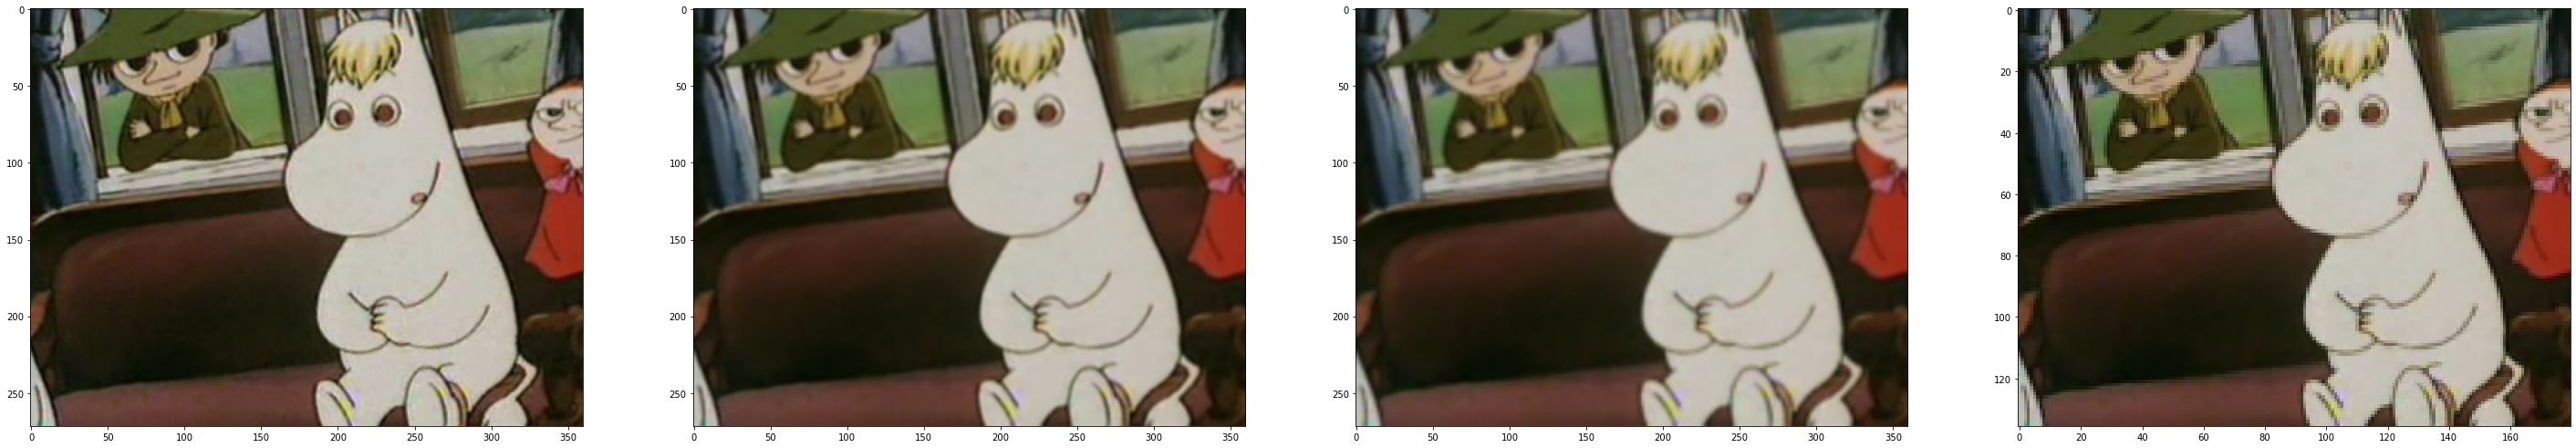

In [17]:
test_image = files[random.randint(0, len(files))]
#test_image = files[100]
test_image = pyplot.imread(os.path.join('../../datasets/dataset_07/full', test_image))
small_image = resize(test_image,(test_image.shape[0]//2, test_image.shape[1]//2))
print(small_image[10, 10, :])
pred_image = np.expand_dims(small_image, 0)
print(pred_image[:, 10, 10, :])
pred_image = 255 * autoencoder.predict(pred_image)
#print(pred_image[0][:10])
pred_image = np.array(pred_image, dtype=int)
#mse_og = np.square(test_image - small_image).mean(axis=None)
#mse = np.square(test_image - pred_image).mean(axis=None)
#print(f'MSE:\nOriginal: {mse_og}\nAutoencoder: {mse}')
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(test_image)
ax = plt.subplot(10, 10, 2)
plt.imshow(pred_image[0])
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(small_image, (2*small_image.shape[0], 2*small_image.shape[1])))
ax = plt.subplot(10, 10, 4)
plt.imshow(small_image)

(544, 720, 3)
(16, 136, 180, 3)
(16, 272, 360, 3)
(1088, 1440, 3)
[150 161 119]
[0.58039216 0.62745098 0.43921569]
[0.55998325 0.61376977 0.45148793]
[0.52085233 0.56622076 0.36742878]


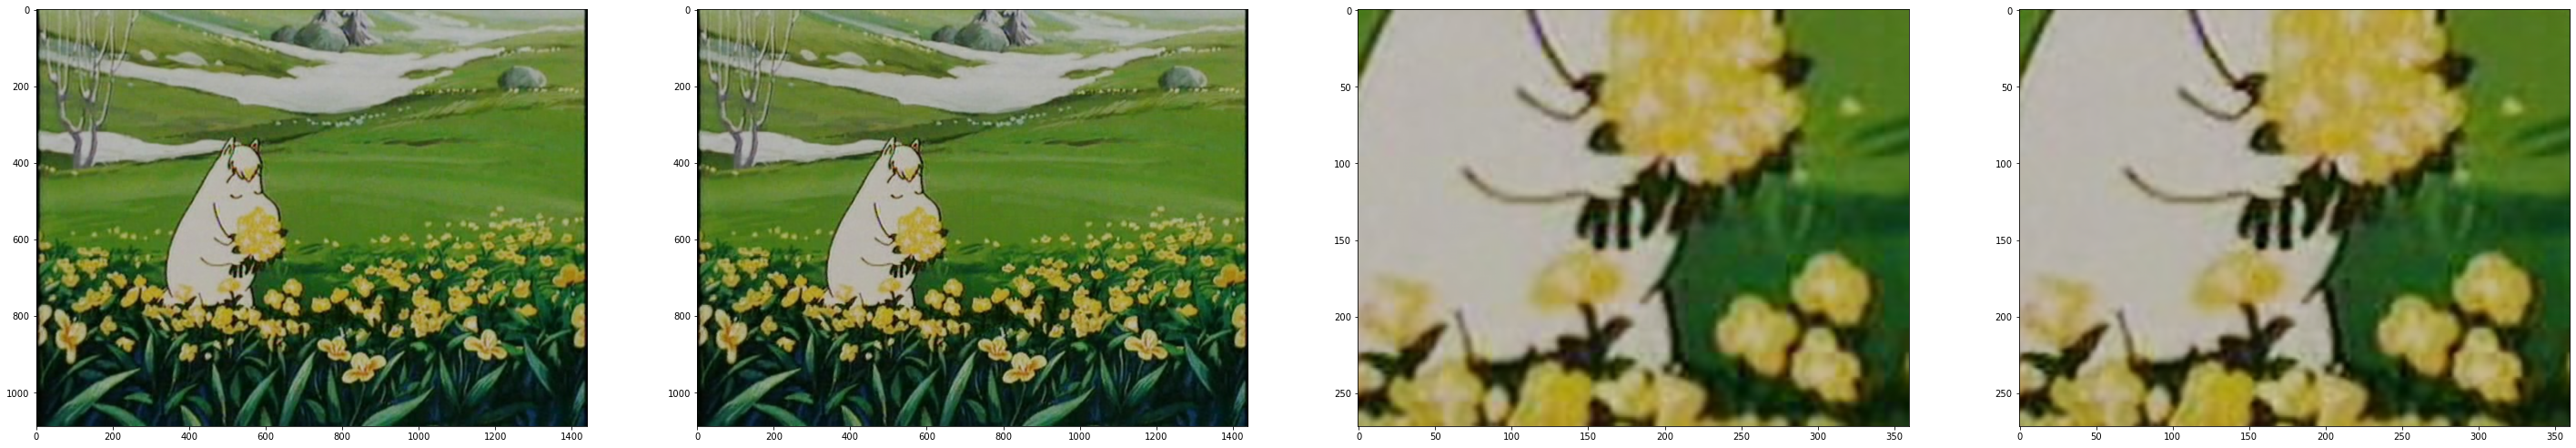

In [18]:
full_image = pyplot.imread(os.path.join('../../datasets/full_frames', '3.jpg'))
full_size = full_image.shape
print(full_size)
quater_images = np.empty((16, full_size[0]//4, full_size[1]//4, 3), dtype=float)
quater_images_scaled = np.empty((16, full_size[0]//2, full_size[1]//2, 3), dtype=float)
scaled_image = np.empty((full_size[0]*2, full_size[1]*2, 3), dtype=float)
k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0])
        x_e = int(((i+1)/4.)*full_size[0])
        y_s = int((j/4.)*full_size[1])
        y_e = int(((j+1)/4.)*full_size[1])
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #temp = full_image[x_s:x_e, y_s:y_e]
        #temp = resize(temp,(full_size[0]//2, full_size[1]//2))
        quater_images[k] = (1./255) * full_image[x_s:x_e, y_s:y_e]
        k += 1
print(quater_images.shape)

for i in range(0, 16):
    temp = np.expand_dims(quater_images[i], 0)
    temp = autoencoder.predict(temp)
    quater_images_scaled[i] = temp[:]
print(quater_images_scaled.shape)
print(scaled_image.shape)

k = 0
for i in range(0, 4):
    for j in range(0, 4):
        x_s = int((i/4.)*full_size[0]*2)
        x_e = int(((i+1)/4.)*full_size[0]*2)
        y_s = int((j/4.)*full_size[1]*2)
        y_e = int(((j+1)/4.)*full_size[1]*2)
        #print(f'x: {x_s}:{x_e} | {y_s}:{y_e}')
        #print(scaled_image[x_s:x_e, y_s:y_e].shape)
        scaled_image[x_s:x_e, y_s:y_e] = quater_images_scaled[k]
        k += 1

print(full_image[40][40][:])
print(quater_images[0][10][10][:])
print(quater_images_scaled[0][10][10][:])
print(scaled_image[40][40][:])
seqment = 9
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(resize(full_image, (2*full_size[0], 2*full_size[1])))
ax = plt.subplot(10, 10, 2)
plt.imshow(scaled_image)
ax = plt.subplot(10, 10, 3)
plt.imshow(resize(quater_images[seqment], (2*quater_images.shape[1], 2*quater_images.shape[2])))
ax = plt.subplot(10, 10, 4)
plt.imshow(quater_images_scaled[seqment])

In [ ]:
from cv2 import imwrite
#scaled_image = np.array(255 * scaled_image, dtype = int)
#full_image = np.array(255 * full_image, dtype = int)
temp = scaled_image[:][:][2]
scaled_image[:][:][2] = scaled_image[:][:][0]
scaled_image[:][:][0] = temp
imwrite('../datasets/full_frames/' + '3_og.jpg', 255 * resize(full_image, (full_size[0] * 2, full_size[1] * 2)))
imwrite('../datasets/full_frames/' + '3_scaled.jpg', 255 * scaled_image)